<a href="https://colab.research.google.com/github/melirandazzo/trabajo_ciencia_datos/blob/main/NPL_Randazzo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP para carta natal personal

El análisis de cartas natales ha sido tradicionalmente un proceso manual, reservado para expertos en astrología, lo que limita su accesibilidad y comprensión para el público general.
Este proyecto utiliza técnicas de procesamiento de lenguaje natural (NLP) para automatizar la interpretación de cartas natales, con el objetivo de identificar aspectos clave de la personalidad y explicar el significado de los componentes astrológicos de manera clara y estructurada.

La motivación principal es ofrecer una herramienta que combine el conocimiento astrológico con la tecnología, permitiendo que personas sin formación en astrología puedan comprender su carta natal.
Este enfoque es útil tanto para aficionados que buscan autoexploración como para profesionales interesados en aplicar análisis astrológico en contextos personalizados.

Este proyecto busca transformar un documento textual extenso en una representación estructurada y procesable, que permita un análisis eficiente y accesible.

Procesar y estructurar el contenido astrológico automatiza la extracción de información clave, permitiendo:

- Personalización en aplicaciones de bienestar y desarrollo personal.
- Generación de insights automáticos en plataformas de contenido.
- Análisis masivo de cartas natales para identificar patrones comunes en segmentos de usuarios.

***Preguntas/Hipótesis a Resolver***

- Es posible automatizar la identificación y estructuración de los componentes principales de una carta natal (signos, planetas, casas, aspectos astrológicos) utilizando NLP?
- Qué aspectos clave de la personalidad pueden inferirse automáticamente desde una carta natal, y cómo se relacionan entre sí los diferentes componentes astrológicos?
- Cómo puede este análisis facilitar la interpretación para personas sin conocimientos previos de astrología?
 -Es viable generar un modelo que proporcione interpretaciones consistentes y significativas, comparables al análisis humano?

## Instalar librerias

In [1]:
!pip install python-docx==0.8.11
!pip install nltk
!pip install spacy
!pip install textblob
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 37.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for python-docx: filename=python_docx-0.8.11-py3-none-any.whl size=184488 sha256=8f2ee4859c69770df0eaff3ad6ceb35f7f014c1446dcbb02aec377d87ff1297e
  Stored in directory: /root/.cache/pip/wheels/80/27/06/837436d4c3bd989b957a91679966f207bfd71d358d63a8194d
Successfully built python-docx


In [31]:
import requests
from docx import Document
import nltk
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
from nltk.stem import PorterStemmer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import pipeline
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spacy import displacy
import networkx as nx
import plotly.express as px
import plotly.io as pio
import pandas as pd
from spacy.training import Example
from spacy.tokens import Span
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize

In [3]:
nltk.download('punkt_tab')
nltk.download('stopwords')
!python -m spacy download en_core_web_sm
nltk.download('averaged_perceptron_tagger_eng')
nltk_stopwords = nltk.corpus.stopwords.words('english')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 73.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

### Carga de documento

In [4]:
# Descargar el documento
def download_file(url, local_path):
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

# Cargar el archivo .docx
def extract_text_from_docx(file_path):
    document = Document(file_path)
    full_text = []
    for para in document.paragraphs:
        full_text.append(para.text)
    return '\n'.join(full_text)

url = 'https://github.com/melirandazzo/trabajo_ciencia_datos/raw/main/Carta_natal.docx'
local_file_path = 'Carta_natal.docx'
download_file(url, local_file_path)

# Ruta del archivo .docx (local path)
file_path = local_file_path

# Extraer el texto
extracted_text = extract_text_from_docx(file_path)


### Limpieza y tokenización

In [5]:
def preprocess_text(text):
    # Convertir el texto a minúsculas
    text = text.lower()
    # Remover caracteres no alfabéticos
    text = re.sub(r'[^a-záéíóúüñ\s]', '', text)
    # Tokenizar el texto
    tokens = word_tokenize(text)
    # Remover stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens


# Preprocesar el texto y mostrar los tokens
preprocessed_tokens = preprocess_text(extracted_text)
print("\nTokens preprocesados:")
print(preprocessed_tokens)



Tokens preprocesados:
['st', 'house', 'ascendant', 'asc', 'physical', 'personality', 'ascendant', 'asc', 'symbolizes', 'basic', 'personality', 'traits', 'physical', 'appearance', 'temperament', 'behaviour', 'relationship', 'life', 'first', 'impression', 'person', 'gives', 'ascendant', 'capricorn', 'capricorn', 'ruler', 'saturn', 'people', 'capricorn', 'ascendant', 'must', 'first', 'become', 'aware', 'two', 'opposing', 'sides', 'one', 'obedience', 'performing', 'duties', 'properly', 'need', 'manage', 'energy', 'well', 'requires', 'discipline', 'selfcontrol', 'must', 'achieve', 'social', 'prestige', 'recognition', 'side', 'ability', 'organize', 'practical', 'matters', 'achieve', 'goals', 'also', 'ability', 'enjoy', 'sensual', 'pleasures', 'ruler', 'ascendant', 'saturn', 'people', 'tend', 'act', 'slowly', 'caution', 'avoid', 'kind', 'control', 'love', 'solitude', 'hate', 'crowds', 'want', 'stand', 'isolate', 'others', 'actions', 'valued', 'time', 'may', 'become', 'politicians', 'consulta

In [6]:
# Procesar con spaCy
nlp = spacy.load("en_core_web_sm")
extracted_text_nlp = nlp(extracted_text)

In [7]:
# Tokenización y lematización
tokens = [token.lemma_ for token in extracted_text_nlp if not token.is_stop and not token.is_punct]
print(tokens)


['1st', 'house', 'Ascendant', 'ASC', '\n', 'physical', 'personality', '\n', 'Ascendant', 'ASC', 'symbolizes', 'basic', 'personality', 'trait', 'physical', 'appearance', 'temperament', 'behaviour', 'relationship', 'life', 'impression', 'person', 'give', '\n\n', 'Ascendant', 'Capricorn', 'Capricorn', 'ruler', 'Saturn', '\n', 'People', 'Capricorn', 'Ascendant', 'aware', 'oppose', 'side', 'obedience', 'perform', 'duty', 'properly', 'need', 'manage', 'energy', 'require', 'discipline', 'self', 'control', 'achieve', 'social', 'prestige', 'recognition', 'ability', 'organize', 'practical', 'matter', 'achieve', 'goal', 'ability', 'enjoy', 'sensual', 'pleasure', '\n\n', 'ruler', 'Ascendant', 'Saturn', '\n', 'people', 'tend', 'act', 'slowly', 'caution', 'avoid', 'kind', 'control', 'love', 'solitude', 'hate', 'crowd', 'want', 'stand', 'isolate', 'action', 'value', 'time', 'politician', 'consultant', 'engineer', 'etc', 'main', 'feature', 'endurance', '\n\n', 'ruler', 'Ascendant', 'Saturn', 'Capricor

In [8]:
# Establecer aspectos y palabras clave de astrologia
# Lista de signos zodiacales y sus elementos
zodiac_signs = {
    'aries': 'fire', 'taurus': 'earth', 'gemini': 'air', 'cancer': 'water',
    'leo': 'fire', 'virgo': 'earth', 'libra': 'air', 'scorpio': 'water',
    'sagittarius': 'fire', 'capricorn': 'earth', 'aquarius': 'air', 'pisces': 'water'
}

# Añadir detección con regex para casas astrales
def detect_houses(text):
    house_pattern = re.compile(r"\b([1-9]|1[0-2])(st|nd|rd|th) house\b")
    matches = house_pattern.findall(text)
    return [f"{m[0]}{m[1]} house" for m in matches]

# Lista personalizada de palabras clave
planets = ["Mercury", "Venus", "Mars", "Jupiter", "Saturn", "Uranus", "Neptune", "Pluto"]
signs = ["Aries", "Taurus", "Gemini", "Cancer", "Leo", "Virgo", "Libra", "Scorpio", "Sagittarius", "Capricorn", "Aquarius", "Pisces"]
astrological_aspects = ["Sun", "Moon", "Ascendant", "Lilith", "Chiron", "North Node", "South Node"]
houses = detect_houses(extracted_text)


In [9]:
# Detectar palabras clave
keywords = [token.text for token in extracted_text_nlp if token.text in planets + houses + signs + astrological_aspects]
# Eliminar duplicados
unique_keywords = list(set(keywords))
print("Palabras clave encontradas:", unique_keywords)

Palabras clave encontradas: ['Venus', 'Taurus', 'Lilith', 'Neptune', 'Ascendant', 'Scorpio', 'Gemini', 'Chiron', 'Sun', 'Virgo', 'Saturn', 'Capricorn', 'Pisces', 'Moon', 'Mars', 'Jupiter', 'Uranus', 'Pluto', 'Aries', 'Libra', 'Sagittarius', 'Mercury']


In [10]:
# Estadísticas básicas
num_sentences = len(list(extracted_text_nlp.sents))
num_words = len(tokens)
print(f"Número de oraciones: {num_sentences}, Número de palabras: {num_words}")

# Frecuencia de palabras clave
freq = Counter(keywords)
print("Frecuencia de palabras clave:", freq)


Número de oraciones: 398, Número de palabras: 3672
Frecuencia de palabras clave: Counter({'Venus': 34, 'Sun': 33, 'Saturn': 29, 'Moon': 28, 'Mercury': 24, 'Uranus': 24, 'Neptune': 22, 'Mars': 19, 'Pluto': 16, 'Jupiter': 15, 'Ascendant': 14, 'Capricorn': 11, 'Gemini': 9, 'Chiron': 8, 'Lilith': 6, 'Taurus': 5, 'Pisces': 5, 'Libra': 3, 'Sagittarius': 3, 'Scorpio': 3, 'Aries': 2, 'Virgo': 2})


In [11]:
pio.templates.default = "plotly_dark"

# Convertir a DataFrame de pandas para usar con plotly
df_freq = pd.DataFrame(list(freq.items()), columns=["Palabra clave", "Frecuencia"])

# Crear el gráfico de barras con Plotly
fig = px.bar(df_freq, x="Palabra clave", y="Frecuencia",
             title="Frecuencia de palabras clave en la carta natal",
             labels={"Palabra clave": "Palabras clave", "Frecuencia": "Frecuencia"},
             color="Frecuencia", color_continuous_scale="Magma")

# Rotar las etiquetas del eje x
fig.update_layout(xaxis_tickangle=-45)

# Mostrar el gráfico
fig.show()


In [12]:
# Renderizar árbol sintáctico
displacy.render(extracted_text_nlp, style="dep", jupyter=True)

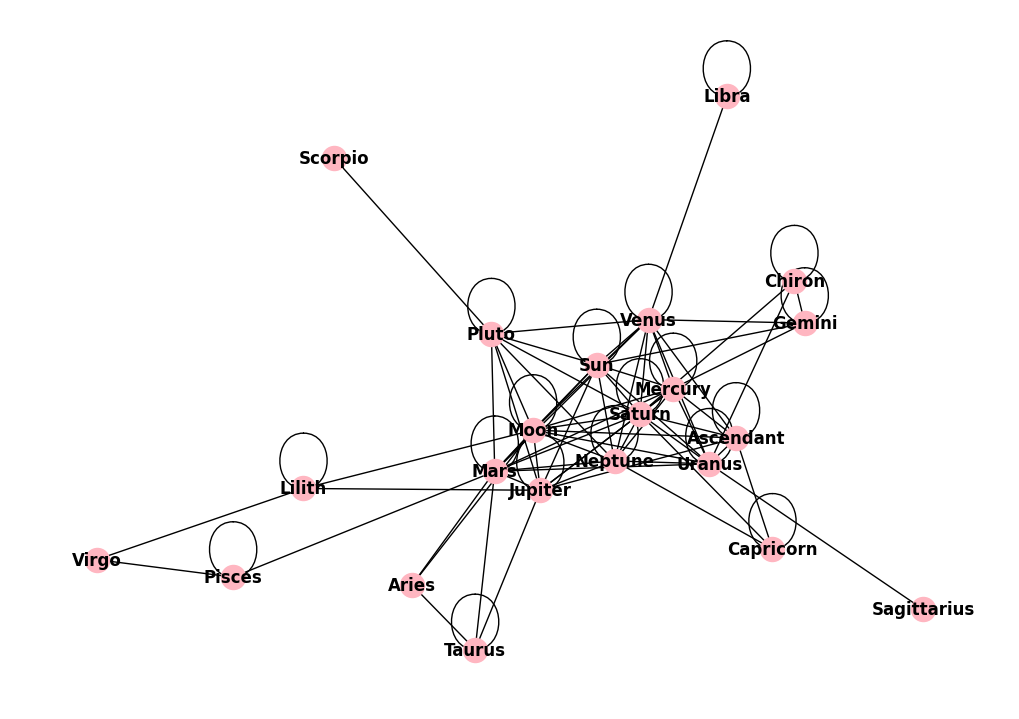

In [13]:
# Grafo para mostrar cómo se relacionan planetas, casas y signos.
G = nx.Graph()
for sent in extracted_text_nlp.sents:
    entities = [token.text for token in sent if token.text in planets + houses + signs + astrological_aspects]
    for i in range(len(entities)):
        for j in range(i + 1, len(entities)):
            G.add_edge(entities[i], entities[j])

# Dibujar el grafo
plt.figure(figsize=(10, 7))
nx.draw(G, with_labels=True, node_color="lightpink", font_weight="bold")
plt.show()


In [14]:
# Clasificar oraciones por temas
themes = {}
for sent in extracted_text_nlp.sents:
    planets_in_sent = [token.text for token in sent if token.text in planets]
    houses_in_sent = [token.text for token in sent if token.text in houses]
    signs_in_sent = [token.text for token in sent if token.text in signs]
    aspects_in_sent = [token.text for token in sent if token.text in astrological_aspects]

    if planets_in_sent:
        themes[sent.text] = {
            "planets": planets_in_sent,
            "houses": houses_in_sent,
            "signs": signs_in_sent,
            "aspects": aspects_in_sent
        }

# Mostrar resultados
for sentence, details in themes.items():
    print(f"Oración: {sentence}")
    print(f"Detalles: {details}")


Oración: Ascendant in Capricorn (Capricorn ruler is Saturn)
People with Capricorn Ascendant must first become aware of their two opposing sides.
Detalles: {'planets': ['Saturn'], 'houses': [], 'signs': ['Capricorn', 'Capricorn', 'Capricorn'], 'aspects': ['Ascendant', 'Ascendant']}
Oración: more -»

The ruler of the Ascendant - Saturn

Detalles: {'planets': ['Saturn'], 'houses': [], 'signs': [], 'aspects': ['Ascendant']}
Oración: The ruler of the Ascendant (Saturn) in Capricorn
These people raise slowly but steadily without others noticing.
Detalles: {'planets': ['Saturn'], 'houses': [], 'signs': ['Capricorn'], 'aspects': ['Ascendant']}
Oración: The ruler of the Ascendant (Saturn) in the 12th House

Detalles: {'planets': ['Saturn'], 'houses': [], 'signs': [], 'aspects': ['Ascendant']}
Oración: Ascendant aspects
Square Moon (3°22’, Separating)
Trine Jupiter (6°26’, Separating)
Contra-Parallel Mercury (0°12’)

10th house - Medium Coeli (MC)
Career, prestige and reputation
Medium Coeli (MC

In [15]:
# Buscar verbos y sus relaciones
for token in extracted_text_nlp:
    if token.pos_ == "VERB":
        related_keywords = [child.text for child in token.children if child.text in planets + signs + houses + astrological_aspects]
        if related_keywords:
            print(f"Verbo: {token.text}, Relacionado con: {related_keywords}")

Verbo: expands, Relacionado con: ['Jupiter']
Verbo: manifest, Relacionado con: ['Mars']
Verbo: behave, Relacionado con: ['Aries']
Verbo: symbolizes, Relacionado con: ['Sun']
Verbo: creates, Relacionado con: ['Sun', 'Sun']
Verbo: gives, Relacionado con: ['Sun']
Verbo: tells, Relacionado con: ['Moon']
Verbo: means, Relacionado con: ['Moon', 'Moon']
Verbo: indicates, Relacionado con: ['Moon']
Verbo: aspects, Relacionado con: ['Moon', 'Sun']
Verbo: learning, Relacionado con: ['Mercury']
Verbo: have, Relacionado con: ['Mercury']
Verbo: feels, Relacionado con: ['Mercury']
Verbo: represents, Relacionado con: ['Mercury']
Verbo: indicates, Relacionado con: ['Mercury']
Verbo: symbolizes, Relacionado con: ['Moon']
Verbo: tells, Relacionado con: ['Venus']
Verbo: causes, Relacionado con: ['Venus']
Verbo: symbolizes, Relacionado con: ['Uranus']
Verbo: tells, Relacionado con: ['Mars']
Verbo: gives, Relacionado con: ['Mars']
Verbo: suggests, Relacionado con: ['Mars']
Verbo: aspects, Relacionado con: [

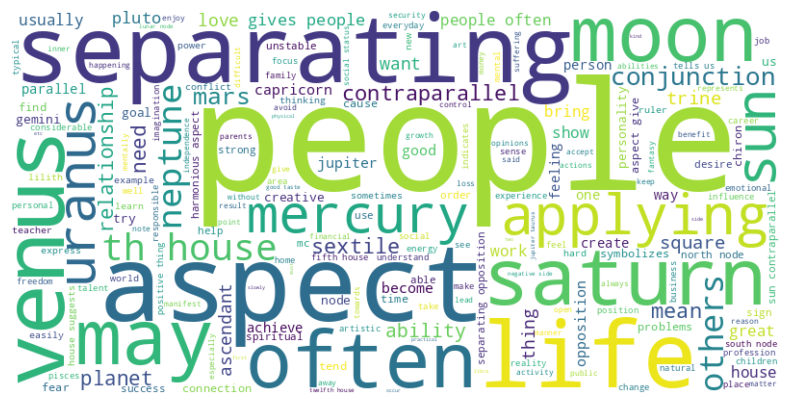

In [16]:
def plot_wordcloud(tokens, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(tokens))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Visualizar las palabras con una nube de palabras
plot_wordcloud(preprocessed_tokens, '')

# Evaluar caracteristicas personales


Frecuencia de signos zodiacales:
Counter({'capricorn': 11, 'gemini': 9, 'taurus': 5, 'pisces': 5, 'libra': 3, 'sagittarius': 3, 'scorpio': 3, 'aries': 2, 'virgo': 2})


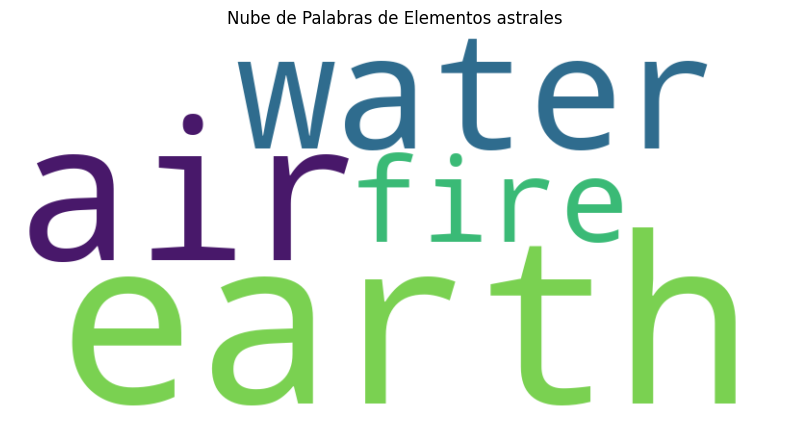

In [17]:
# Filtrar y contar palabras clave
def filter_and_count_keyword(tokens, keywordList):
    filtered = [word for word in tokens if word in keywordList]
    counts = Counter(filtered)
    return counts

def plot_element_wordcloud(sign_counts):
    # Convertir los signos a sus elementos correspondientes
    element_counts = Counter()
    for sign, count in sign_counts.items():
        element = zodiac_signs[sign]
        element_counts[element] += count

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(element_counts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nube de Palabras de Elementos astrales')
    plt.show()

# Filtrar y contar signos zodiacales
zodiac_sign_lower = [zodiac_sign.lower() for zodiac_sign in zodiac_signs]
zodiac_sign_counts = filter_and_count_keyword(preprocessed_tokens, zodiac_sign_lower)
print("\nFrecuencia de signos zodiacales:")
print(zodiac_sign_counts)

plot_element_wordcloud(zodiac_sign_counts)

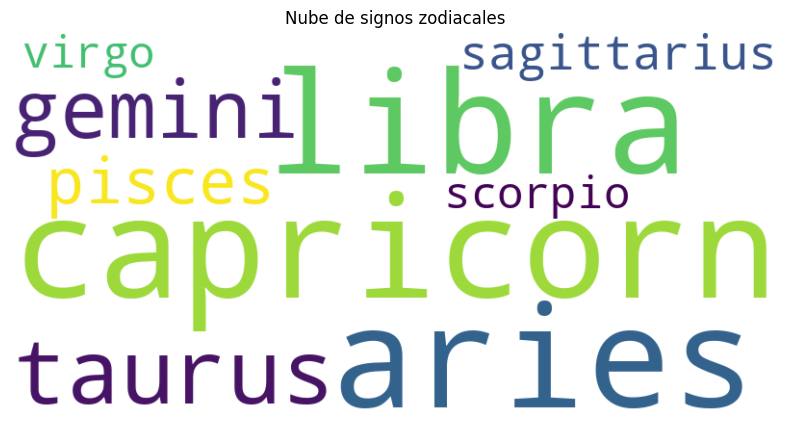

In [18]:
signs_lower = [sign.lower() for sign in signs]
plot_wordcloud(filter_and_count_keyword(preprocessed_tokens, signs_lower), "Nube de signos zodiacales")

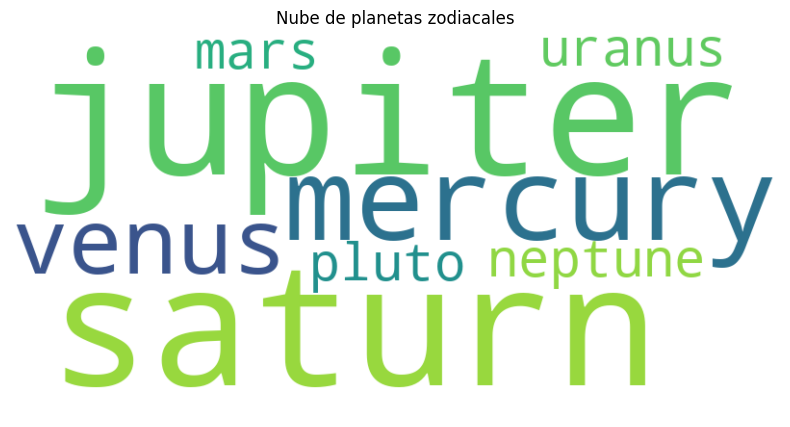

In [19]:
planets_lower = [planet.lower() for planet in planets]
plot_wordcloud(filter_and_count_keyword(preprocessed_tokens, planets_lower), "Nube de planetas zodiacales")

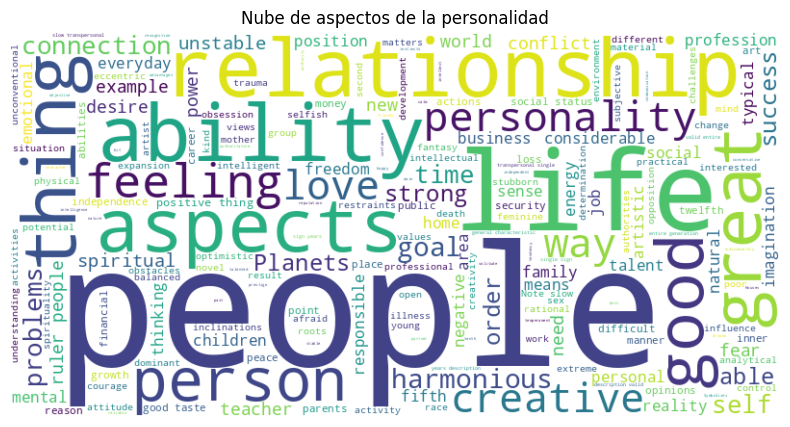

In [21]:
# Función para generar palabras clave
def generate_filtered_words(text, exclusion_lists):
    # Procesar el texto con spaCy
    doc = text

    # Combinar todas las listas de palabras clave en un solo conjunto para exclusión
    exclusion_set = set(word.lower() for lst in exclusion_lists for word in lst)

    # Expresión regular para números ordinales (e.g., "4th", "12th")
    ordinal_pattern = re.compile(r"\b[0-9]+(st|nd|rd|th)\b", re.IGNORECASE)

    # Extraer adjetivos y sustantivos, asegurando que no estén en las listas de exclusión
    filtered_words = [
        token.text
        for token in doc
        if token.pos_ in ["ADJ", "NOUN"]
        and not token.is_stop
        and token.text.lower() not in exclusion_set
        and not ordinal_pattern.match(token.text)    # No es un número ordinal
    ]

    return filtered_words


# Detectar casas astrales
houses = detect_houses(extracted_text)

# Listas personalizadas de palabras a excluir
other = ["House", "Aspect", "Conjunction", "Astrology", "Planet"]

# Generar lista filtrada
filtered_words = generate_filtered_words(
    extracted_text_nlp,
    exclusion_lists=[planets, signs, astrological_aspects, houses, other]
)

# Generar la nube de palabras
plot_wordcloud(filtered_words, "Nube de aspectos de la personalidad")


In [22]:
# Función para encontrar relaciones dentro de una oración
def find_related_keywords(doc, keywords):
    related = []
    for sent in doc.sents:  # Iterar sobre oraciones
        found = [ent.text for ent in sent.ents if ent.text in keywords]
        if len(found) > 1:  # Si hay más de una palabra clave en la oración
            related.append((sent.text))
    return related

# Palabras clave a buscar
keywords = planets + houses + signs + astrological_aspects

# Detectar relaciones
relationships = find_related_keywords(extracted_text_nlp, keywords)

for relationship in relationships:
  print(relationship)

Ascendant in Capricorn (Capricorn ruler is Saturn)
People with Capricorn Ascendant must first become aware of their two opposing sides.
The ruler of the Ascendant (Saturn) in Capricorn
These people raise slowly but steadily without others noticing.
The ruler of the Ascendant (Saturn) in the 12th House

Mars fights, Saturn limits, Jupiter expands..

Sign in which the planet is located determines how the planet is manifesting itself, for example Mars may manifest itself in a way Aries would behave (vigorously and irritably) or in the manner of Taurus (more slowly, gradually and consistently)

The position of the Sun may tell us which profession would best suit the character of a person.

Sun in Gemini
People born under the sign of Gemini are people of many talents and they are able to use their skills in both theory and practice.
more -»

Sun in the 5th House
The Sun in the fifth house creates very creative people with a very strong desire for self-expression.
Sun aspects
Sextile Moon (5

## Lematización

In [23]:
# Cargar el modelo de spaCy
nlp = spacy.load("en_core_web_sm")

doc = nlp(extracted_text)
lemmatized_text = [(token.text, token.lemma_) for token in doc]
print("Lematización:")
for word, lemma in lemmatized_text:
    print(f"{word} -> {lemma}")

Streaming output truncated to the last 5000 lines.
° -> °
22 -> 22
’ -> '
, -> ,
Applying -> apply
) -> )

 -> 

Opposition -> Opposition
Mercury -> Mercury
( -> (
5 -> 5
° -> °
54 -> 54
’ -> '
, -> ,
Separating -> Separating
) -> )

 -> 

Opposition -> Opposition
Venus -> Venus
( -> (
5 -> 5
° -> °
56 -> 56
’ -> '
, -> ,
Separating -> Separating
) -> )

 -> 

Conjunction -> Conjunction
Uranus -> Uranus
( -> (
0 -> 0
° -> °
32 -> 32
’ -> '
, -> ,
Applying -> apply
) -> )

 -> 

Contra -> Contra
- -> -
Parallel -> Parallel
Sun -> Sun
( -> (
0 -> 0
° -> °
43 -> 43
’ -> '
) -> )

 -> 

Contra -> Contra
- -> -
Parallel -> Parallel
Venus -> Venus
( -> (
0 -> 0
° -> °
53 -> 53
’ -> '
) -> )

 -> 

Parallel -> Parallel
Neptune -> Neptune
( -> (
0 -> 0
° -> °
10 -> 10
’ -> '
) -> )


  -> 

 
Uranus -> Uranus
- -> -
Originality -> Originality
, -> ,
freedom -> freedom
, -> ,
revolution -> revolution

 -> 

Uranus -> Uranus
is -> be
the -> the
power -> power
of -> of
awakening -> awakening
, ->

## Stemming

In [24]:
ps = PorterStemmer()
stemmed_text = [ps.stem(word) for word in preprocessed_tokens]
print("\nStemming:")
print(stemmed_text)


Stemming:
['st', 'hous', 'ascend', 'asc', 'physic', 'person', 'ascend', 'asc', 'symbol', 'basic', 'person', 'trait', 'physic', 'appear', 'tempera', 'behaviour', 'relationship', 'life', 'first', 'impress', 'person', 'give', 'ascend', 'capricorn', 'capricorn', 'ruler', 'saturn', 'peopl', 'capricorn', 'ascend', 'must', 'first', 'becom', 'awar', 'two', 'oppos', 'side', 'one', 'obedi', 'perform', 'duti', 'properli', 'need', 'manag', 'energi', 'well', 'requir', 'disciplin', 'selfcontrol', 'must', 'achiev', 'social', 'prestig', 'recognit', 'side', 'abil', 'organ', 'practic', 'matter', 'achiev', 'goal', 'also', 'abil', 'enjoy', 'sensual', 'pleasur', 'ruler', 'ascend', 'saturn', 'peopl', 'tend', 'act', 'slowli', 'caution', 'avoid', 'kind', 'control', 'love', 'solitud', 'hate', 'crowd', 'want', 'stand', 'isol', 'other', 'action', 'valu', 'time', 'may', 'becom', 'politician', 'consult', 'engin', 'etc', 'main', 'featur', 'endur', 'ruler', 'ascend', 'saturn', 'capricorn', 'peopl', 'rais', 'slowli'

## POS Tagging

In [25]:
pos_tags = pos_tag(preprocessed_tokens)
print("\nPOS Tagging:")
for word, tag in pos_tags:
    print(f"{word} -> {tag}")


POS Tagging:
st -> NN
house -> NN
ascendant -> JJ
asc -> JJ
physical -> JJ
personality -> NN
ascendant -> NN
asc -> NN
symbolizes -> VBZ
basic -> JJ
personality -> NN
traits -> NNS
physical -> JJ
appearance -> NN
temperament -> NN
behaviour -> NN
relationship -> NN
life -> NN
first -> JJ
impression -> NN
person -> NN
gives -> VBZ
ascendant -> JJ
capricorn -> JJ
capricorn -> VBN
ruler -> NN
saturn -> NN
people -> NNS
capricorn -> VBP
ascendant -> JJ
must -> MD
first -> RB
become -> VB
aware -> JJ
two -> CD
opposing -> VBG
sides -> NNS
one -> CD
obedience -> NN
performing -> VBG
duties -> NNS
properly -> RB
need -> VBP
manage -> NN
energy -> NN
well -> RB
requires -> VBZ
discipline -> JJ
selfcontrol -> NN
must -> MD
achieve -> VB
social -> JJ
prestige -> NN
recognition -> NN
side -> NN
ability -> NN
organize -> VB
practical -> JJ
matters -> NNS
achieve -> VBP
goals -> NNS
also -> RB
ability -> NN
enjoy -> VBP
sensual -> JJ
pleasures -> NNS
ruler -> VBP
ascendant -> JJ
saturn -> NN
peopl

## Análisis de sentimiento

In [26]:
# Crear un objeto TextBlob para el análisis
blob = TextBlob(extracted_text)

sentimiento = blob.sentiment

print(f"Polaridad: {sentimiento.polarity}")
print(f"Sujeción: {sentimiento.subjectivity}")

Polaridad: 0.13688797464068223
Sujeción: 0.5303579698480421


Polaridad: 0.1369 -> No hay una emoción intensa; el tono del documento parece ser neutral o moderadamente optimista, lo cual es coherente con textos descriptivos o informativos como los que suelen encontrarse en una carta natal.

Sujeción: 0.5304 -> El texto combina elementos objetivos y subjetivos. Combina descripciones generales (como características comunes de signos o planetas) combinadas con interpretaciones más personalizadas (las influencias específicas según la carta natal).

El análisis sugiere que el tono es principalmente informativo y ligeramente positivo, con un balance entre afirmaciones generales y apreciaciones individuales. La polaridad moderada indica que el texto no busca transmitir emociones fuertes, lo cual es consistente con el objetivo de describir aspectos clave de la personalidad de forma analítica.

In [32]:
extracted_text_list = sent_tokenize(extracted_text)

sid = SentimentIntensityAnalyzer()
for sentence in extracted_text_list:
  print(sentence)
  ss = sid.polarity_scores(sentence)
  for k in sorted(ss):
    print('{0}: {1}, '.format(k, ss[k]), end='')

1st house - Ascendant (ASC)
Physical personality
Ascendant (ASC) - Symbolizes basic personality traits such as physical appearance, temperament, behaviour, relationship to life and the first impression the person gives.
compound: 0.2263, neg: 0.0, neu: 0.934, pos: 0.066, Ascendant in Capricorn (Capricorn ruler is Saturn)
People with Capricorn Ascendant must first become aware of their two opposing sides.
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, One is obedience and performing their duties properly.
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, They need to manage energy well and this requires discipline and self-control.
compound: 0.4939, neg: 0.0, neu: 0.704, pos: 0.296, They must achieve some social prestige and recognition.
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, The other side is the ability to organize practical matters and achieve their goals, and also the ability to enjoy sensual pleasures.
compound: 0.8689, neg: 0.0, neu: 0.59, pos: 0.41, ... more -»

The ruler of the A

## TF-IDF

In [27]:
# Crear el vectorizador TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')  # Esto elimina palabras comunes (como "the", "and", etc.)

# Ajustar el modelo y transformar el texto
tfidf_matrix = vectorizer.fit_transform([extracted_text])

# Obtener los nombres de las características (palabras)
palabras = vectorizer.get_feature_names_out()

# Convertir la matriz TF-IDF en un formato más legible
tfidf_scores = tfidf_matrix.toarray()

# Mostrar los resultados (palabras y sus respectivos TF-IDF scores)
for palabra, score in zip(palabras, tfidf_scores[0]):
    print(f"{palabra}: {score:.4f}")

01: 0.0141
03: 0.0141
10: 0.0283
10th: 0.0283
12: 0.0141
12th: 0.0283
14: 0.0141
16: 0.0141
18: 0.0188
1st: 0.0094
21: 0.0141
22: 0.0283
23: 0.0141
25: 0.0141
26: 0.0283
27: 0.0141
28: 0.0141
2nd: 0.0047
305: 0.0047
31: 0.0141
32: 0.0141
33: 0.0141
38: 0.0141
3rd: 0.0047
40: 0.0141
41: 0.0141
43: 0.0141
45: 0.0141
47: 0.0141
49: 0.0141
4th: 0.0141
50: 0.0141
53: 0.0283
54: 0.0283
55: 0.0141
56: 0.0141
5th: 0.0188
6th: 0.0094
7th: 0.0047
8th: 0.0047
9th: 0.0047
abilities: 0.0188
ability: 0.0753
able: 0.0330
accept: 0.0188
accepted: 0.0047
accepting: 0.0047
accordance: 0.0047
according: 0.0047
achieve: 0.0471
acknowledged: 0.0047
acquaintances: 0.0047
act: 0.0047
actions: 0.0188
active: 0.0047
activities: 0.0141
activity: 0.0188
actors: 0.0094
adam: 0.0094
adapt: 0.0047
administrators: 0.0047
advantages: 0.0094
adventurous: 0.0094
affairs: 0.0094
affected: 0.0047
affection: 0.0094
affectionate: 0.0047
affects: 0.0094
afraid: 0.0141
ahead: 0.0047
aim: 0.0047
air: 0.0094
alcohol: 0.0094
al

# Reconocimiento de Entidades Nombradas (NER)

In [28]:
# Palabras clave
keywords = {
    "planets": planets,
    "signs": signs,
    "houses": houses,
    "aspects": astrological_aspects
}

doc = extracted_text_nlp

# Identificar entidades personalizadas
entities = []
for token in doc:
    if token.text in keywords["planets"]:
        entities.append((token.idx, token.idx + len(token.text), "PLANET"))
    elif token.text in keywords["signs"]:
        entities.append((token.idx, token.idx + len(token.text), "SIGN"))
    elif any(house in token.text for house in keywords["houses"]):
        entities.append((token.idx, token.idx + len(token.text), "HOUSE"))
    elif token.text in keywords["aspects"]:
        entities.append((token.idx, token.idx + len(token.text), "ASPECT"))

# Añadir las entidades personalizadas al documento
doc.ents = [Span(doc, doc.char_span(start, end).start, doc.char_span(start, end).end, label) for start, end, label in entities]

# Mostrar resultados
for ent in doc.ents:
    print(f"Entidad: {ent.text}, Tipo: {ent.label_}")


Entidad: Ascendant, Tipo: ASPECT
Entidad: Ascendant, Tipo: ASPECT
Entidad: Ascendant, Tipo: ASPECT
Entidad: Capricorn, Tipo: SIGN
Entidad: Capricorn, Tipo: SIGN
Entidad: Saturn, Tipo: PLANET
Entidad: Capricorn, Tipo: SIGN
Entidad: Ascendant, Tipo: ASPECT
Entidad: Ascendant, Tipo: ASPECT
Entidad: Saturn, Tipo: PLANET
Entidad: Ascendant, Tipo: ASPECT
Entidad: Saturn, Tipo: PLANET
Entidad: Capricorn, Tipo: SIGN
Entidad: Ascendant, Tipo: ASPECT
Entidad: Saturn, Tipo: PLANET
Entidad: Ascendant, Tipo: ASPECT
Entidad: Moon, Tipo: ASPECT
Entidad: Jupiter, Tipo: PLANET
Entidad: Mercury, Tipo: PLANET
Entidad: Libra, Tipo: SIGN
Entidad: Libra, Tipo: SIGN
Entidad: Venus, Tipo: PLANET
Entidad: Libra, Tipo: SIGN
Entidad: Venus, Tipo: PLANET
Entidad: Pluto, Tipo: PLANET
Entidad: Sun, Tipo: ASPECT
Entidad: Moon, Tipo: ASPECT
Entidad: Mars, Tipo: PLANET
Entidad: Saturn, Tipo: PLANET
Entidad: Jupiter, Tipo: PLANET
Entidad: Mars, Tipo: PLANET
Entidad: Aries, Tipo: SIGN
Entidad: Taurus, Tipo: SIGN
Entidad

In [33]:
# Generar datos de entrenamiento
training_data = []

for sentence in extracted_text_list:
    entities = []
    occupied_spans = set()
    for label, terms in keywords.items():
        for term in terms:
            # Buscar términos exactos en la oración
            match = re.search(rf"\b{re.escape(term)}\b", sentence)
            if match:
                start, end = match.span()

                # Evitar spans duplicados
                if any(s for s in occupied_spans if start <= s[0] < end or start < s[1] <= end):
                    continue
                # Añadir la posición de la entidad y la etiqueta
                entities.append((match.start(), match.end(), label))
                # Marcar el span ocupado para evitar duplicados
                occupied_spans.add((start, end))

    # Agregar al training_data
    if entities:
        training_data.append((sentence, {"entities": entities}))

for data in training_data:
    print(data)


('1st house - Ascendant (ASC)\nPhysical personality\nAscendant (ASC) - Symbolizes basic personality traits such as physical appearance, temperament, behaviour, relationship to life and the first impression the person gives.', {'entities': [(0, 9, 'houses'), (12, 21, 'aspects')]})
('Ascendant in Capricorn (Capricorn ruler is Saturn)\nPeople with Capricorn Ascendant must first become aware of their two opposing sides.', {'entities': [(43, 49, 'planets'), (13, 22, 'signs'), (0, 9, 'aspects')]})
('... more -»\n\nThe ruler of the Ascendant - Saturn\nThese people tend to act slowly and with caution.', {'entities': [(42, 48, 'planets'), (30, 39, 'aspects')]})
('The ruler of the Ascendant (Saturn) in Capricorn\nThese people raise slowly but steadily without others noticing.', {'entities': [(28, 34, 'planets'), (39, 48, 'signs'), (17, 26, 'aspects')]})
('The ruler of the Ascendant (Saturn) in the 12th House\nThese people are predestined to hide and run away from themselves, to subject themselve

In [34]:
# Crear un modelo base
nlp = spacy.blank("en")

# Añadir el componente NER
ner = nlp.add_pipe("ner", last=True)

# Añadir etiquetas personalizadas
for _, annotations in training_data:
    for ent in annotations["entities"]:
        ner.add_label(ent[2])

# Entrenamiento
optimizer = nlp.initialize()
for i in range(10):  # Número de iteraciones
    for text, annotations in training_data:
        example = Example.from_dict(nlp.make_doc(text), annotations)
        nlp.update([example], sgd=optimizer)

# Guardar el modelo entrenado
nlp.to_disk("custom_astrology_model")


In [35]:
# Renderizar entidades en Jupyter
displacy.render(doc, style="ent", jupyter=True)

# Conclusión final

Este trabajo demuestra que es posible extraer aspectos clave astrológicos y explicar su contenido de manera clara mediante la aplicación de técnicas de procesamiento de lenguaje natural (NLP). El análisis automatizado no solo identifica los componentes principales de una carta natal, sino que también facilita una interpretación comprensible incluso para quienes no poseen conocimientos avanzados en astrología.

Para optimizar la interpretación y el procesamiento, es fundamental complementar el modelo con información astrológica más detallada. Esto permite diferenciar con precisión entre características generales (aplicables a cualquier carta natal) y aspectos personalizados, que dependen de la configuración específica de los elementos en cada caso individual.

Además, estructurar el documento mediante un preprocesamiento adecuado ayuda a separar claramente las descripciones generales de los planetas, signos y aspectos, de las explicaciones particulares basadas en cómo se relacionan estos elementos en la carta de cada persona.

Como trabajo inicial, los resultados obtenidos son muy prometedores, mostrando un alto potencial para interpretar cartas natales de manera automática y escalable. Esto sienta las bases para futuros desarrollos que profundicen en la personalización y precisión del análisis astrológico automatizado.